In [1]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")
plt.style.use("default")
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
from matplotlib import cm
import global_land_mask
import logging
from CMIP6_ridgeplot import CMIP6_ridgeplot
from CMIP6_IO import CMIP6_IO
import matplotlib.dates as mdates
import CMIP6_xgrid_utils

logging.getLogger("xclim").setLevel("ERROR")
logging.getLogger("root").setLevel("ERROR")
sns.set_theme(font_scale=1.5, style="whitegrid")
import pyproj
import sys

import ACTEA_area_calculations

io = CMIP6_IO()

In [2]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)


def get_LME_records_180():
    lme_file = "gs://actea-shared/Shapefiles/LME66_180/LME66_180.shp"
    return gpd.read_file(lme_file)


def create_colors(N):
    color = iter(cm.tab20b(np.linspace(0, 1, N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds, LME, var_name):
    # Extract the polygon defining the boundaries of the LME
    if LME == "Barents Sea":
        shdf = get_LME_records()
    elif LME == "Northern Bering - Chukchi Seas":
        shdf = get_LME_records()
    else:
        raise ValueError("LME not found")

    shdf_sel = shdf[shdf["LME_NAME"] == LME]
    clipped = None

    ds = ds.rio.write_crs("epsg:4326", inplace=True)
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    area_calc = shdf_sel["geometry"].to_crs({"proj": "cea"})

#    print(f"Total area of LME {LME} in km2 {area_calc.area / 10**6}")
    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    # Mask out indices where values are always zero across latitude
    
    clipped = clipped.fillna(0.0)
    always_zero = ~(clipped[var_name].any(dim='time') != 0)
    masked_da = clipped.where(~always_zero)
    return masked_da

In [3]:
import time


def convert_to_180(ds):
    ds = (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby("lon")
    return ds


def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes["time"].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds


def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    
    ("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)
    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)

    return xr.DataArray(mask_data, coords={"lat": lat, "lon": lon}, dims=["lat", "lon"])


def resample_to_monthly(ds: xr.Dataset, LME, var_name, start_time, end_time, ocean_only=True):
    ds = xr.where(((ds < 1.0e-20) | (ds > 1e20)), np.nan, ds)
    ds = convert_to_180(ds)
    ds = ds.sel(time=slice(start_time, end_time))

    ds_lme = convert_time(ds)
    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme)
    if ocean_only:
        ds_lme = ds_lme.where(ds_lme.mask == 1)
  
    ds_lme = get_data_within_LME(ds_lme, LME, var_name)

    return ds_lme.resample(time="M").mean()


def get_area_averaged_ds(
    fname_stats:str,
    scenario:str,
    var_name:str,
    LME:str,
    start_time:str,
    end_time:str,
    ocean_only:bool=True,
    fname_stats_osa:None|str=None
):
    # The ensemble variable names have been renamed to contain _mean and _stdev
    var_name_mean = f"{var_name}_mean"
    if var_name=="uvb":
        # We are interested in the maximum UVB value that are detrimental for marine life.
        var_name_mean = f"{var_name}_mean"
        
    if var_name == "TOZ":
        var_name_mean = "TOZ"
    ds_stats = io.open_dataset_on_gs(fname_stats)
    
    if var_name == "ghi":
        # Account for albedo of GHI
        ds_stats_osa = io.open_dataset_on_gs(fname_stats_osa)
        ds_stats[var_name_mean] = (
                    1 - ds_stats_osa["osa_mean"]) * ds_stats[var_name_mean]
        
   # ds_stats[var_name_mean] = ds_stats[var_name_mean].where(ds_stats[var_name_mean] > 0.0, drop=True)
   # ds_stats[var_name_mean] = ds_stats[var_name_mean].sel(time=ds_stats.time.dt.month.isin([6,7,8]))

    if isinstance(ds_stats, xr.Dataset): # and isinstance(ds_perc, xr.Dataset):
        ds_stats = resample_to_monthly(
            ds_stats, LME, var_name_mean, start_time, end_time, ocean_only=ocean_only
        )
      
        # First we calculate the total area covered by the LME. The total areacello is broadcasted along time
        # axis and used later.
        if ds_stats.lon.ndim == 2:
            lon = ds_stats.lon.values[0, :]
            lat = ds_stats.lat.values[:, 0]
        else:
            lon = ds_stats.lon.values
            lat = ds_stats.lat.values
            
        if "TOZ" not in var_name_mean:
            
             # We assess where light more than light_threshold (W/m2) is changing. For Polar cod, light_threshold is
            # the minimum light level required to feed. If the area where minimum light increases, this can be indicative
            # of areas opening up for feeding given that food levels are increasing too.
            light_threshold = 0.1
            if var_name_mean in ["uvb_mean", "uvb_max"]:
                light_threshold = 0.001

            area_da = ACTEA_area_calculations.calculate_area_of_grid(ds_stats[var_name_mean].isel(time=0), 1.0)
            
            for it in ["min", "max", "mean"]:
                
                ds_stats[f"areacello_{it}"] = xr.DataArray(
                    name=f"areacello_{it}",
                    data=area_da,
                    coords={"lat": lat, "lon": lon},
                    dims=["lat", "lon"],
                )
            
            total_area = area_da.sum(dim=['lat', 'lon'])
            
            # Calculate the total area of the LME as a function of time where light conditions are above threshold.
            ds_stats[f"areacello_min"] = ds_stats[f"areacello_min"].where(ds_stats[var_name_mean]-ds_stats[var_name_mean].std() > light_threshold,  np.nan)   
            ds_stats[f"areacello_mean"] = ds_stats[f"areacello_mean"].where(ds_stats[var_name_mean] > light_threshold,  np.nan)   
            ds_stats[f"areacello_max"] = ds_stats[f"areacello_max"].where(ds_stats[var_name_mean]+ds_stats[var_name_mean].std() > light_threshold,  np.nan)   
            
            print(
                "[calculate_areacello] Average total area {:,.2f} km2".format(
                    total_area.values
                )
            )

        # Average data spatially within the LME as a function of time
        ds_s = ds_stats[var_name_mean].mean({"lat", "lon"}, skipna=True).to_dataset()        
        ds_s = ds_s.assign(std = ds_stats[f"{var_name}_stdev"].mean(dim={"lat","lon"}))
       
        ds_s = ds_s.assign(areacello_min = ds_stats[f"areacello_min"].sum(dim={"lat","lon"}))
        ds_s = ds_s.assign(areacello_max = ds_stats[f"areacello_max"].sum(dim={"lat","lon"}))
        ds_s = ds_s.assign(areacello_mean = ds_stats[f"areacello_mean"].sum(dim={"lat","lon"}))

        if "TOZ" not in var_name_mean:
            ds_s = ds_s.assign(
                std=ds_stats[f"{var_name}_stdev"].mean(dim={"lat", "lon"}, skipna=True)
            )

        df_s = ds_s.to_dataframe().dropna()
        df_s = df_s.reset_index()

        # Calculate the 5 year rolling mean to avoid outliers and extremes
        # and get the trend.
        roll_years = 5
        
        df_s = df_s.resample("A", on="time").mean()
        df_s["roll_mean"] = df_s[var_name_mean].rolling(roll_years).mean()

        if "TOZ" not in var_name_mean:
            df_s["roll_std"] = df_s["std"].rolling(roll_years).mean()
        df_s["model_scenario"] = scenario

        df_s["model_name"] = "ensemble"
        if "TOZ" not in var_name_mean:
            for it in ["min", "max", "mean"]:
                df_s[f"roll_{it}_area"] = (
                    df_s[f"areacello_{it}"].rolling(roll_years).mean()
                )

        df_s["model_scenario"] = scenario
        df_s["model_name_scenario"] = f"ensemble_{scenario}"
        unique = f"ensemble_{scenario}"
        df_s["unique"] = unique

        model_info = {}
        model_info["model_name"] = "ensemble"
        model_info["model_scenario"] = scenario
        model_info["model_var"] = var_name
        formatter = "{:.2f}"
        model_info["model_min"] = formatter.format(np.nanmin(df_s[var_name_mean]))
        model_info["model"] = formatter.format(np.nanmax(df_s[var_name_mean]))
        if var_name_mean == "TOZ":
            return df_s, None, ds_stats

        return df_s, total_area, ds_stats

[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_par_weighted.nc
[calculate_areacello] Average total area 1,366,070.66 km2
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp585/ensemble/CMIP6_ensemble_stats_ssp585_par_weighted.nc
[calculate_areacello] Average total area 1,366,070.66 km2
Created figure Figures/CMIP6_light_par_Northern Bering - Chukchi Seas.png
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_par_weighted.nc
[calculate_areacello] Average total area 2,014,598.80 km2
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp585/ensemble/CMIP6_ensemble_stats_ssp585_par_weighted.nc
[calculate_areacello] Average total area 2,014,598.80 km2
Created figure Figures/CMIP6_light_par_Barents Sea.png


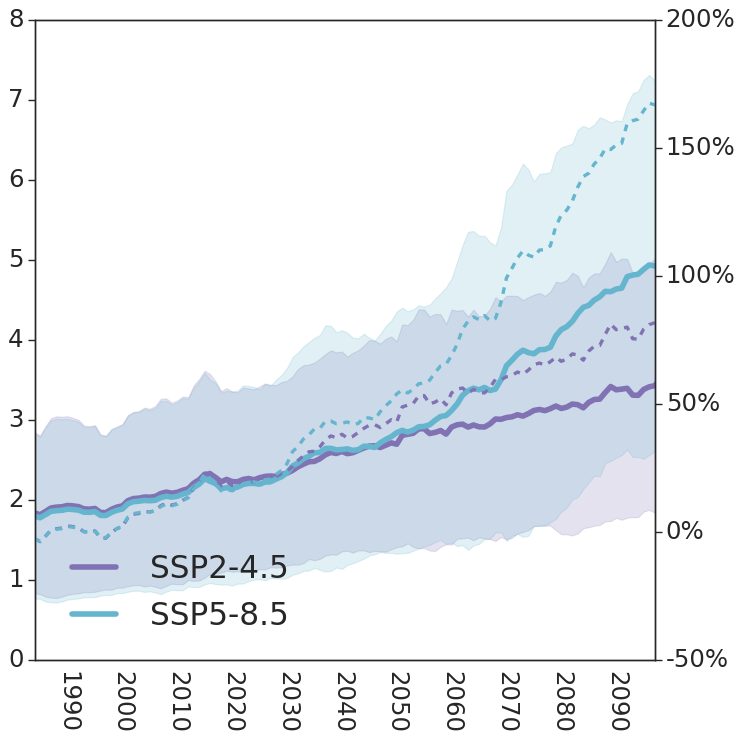

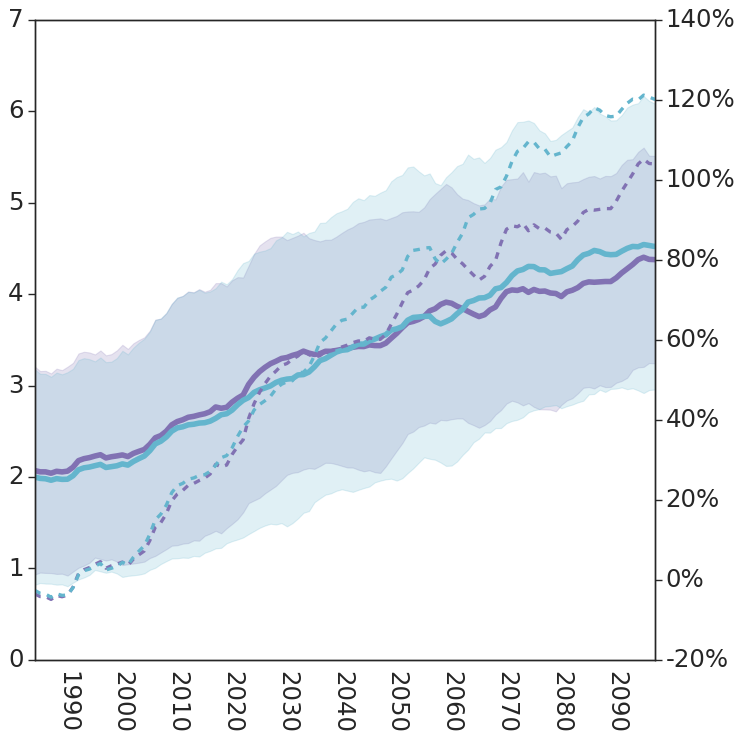

In [4]:
scenarios = ["ssp245", "ssp585"]
member_range = 12
frequency = "A"
period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"
create_ridge_plot=False

root = f"light/ncfiles_nobias"
models = ["ensemble"]
ds_var_names = ["uvb_srf","uvb", "par", "ghi", "uv", "uva", "uvi"]
ds_var_names = ["par"] #,"uvb_srf","uvb"]
#ds_var_names = ["par"]  # ,"uv"]
write_stats_to_file = False
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

LMES = ["Northern Bering - Chukchi Seas", "Barents Sea"]
# if ocean_only is False then we calculate the full integrated average values
# for the entire LME. If set to True we calculate only the values reaching water column.
ocean_only = True

for var_name in ds_var_names:
    for LME in LMES:
        create_maps = True
        saved_total_area_lme = None

        f = plt.figure(figsize=(10, 10))
        gs = f.add_gridspec(1, 1)
        ax = f.add_subplot(gs[0, 0])
        sns.set_palette("tab10")
        loop = 0
        #  palette_tab10 = sns.color_palette("tab10", 10)
        #  colors = [palette_tab10[0], palette_tab10[1], palette_tab10[3]]

        # Colors from deep default seaborn palette found here:
        # https://github.com/mwaskom/seaborn/blob/master/seaborn/palettes.py
        colors_water = ["#8172B3", "#64B5CD"]

        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            fname_stats = f"{root}/{scenario}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}_weighted.nc"
            if var_name=="ghi":
                fname_stats_osa = f"{root}/{scenario}/ensemble/CMIP6_ensemble_stats_{scenario}_osa_weighted.nc"
            if var_name == "TOZ":
                fname_stats = f"light/{scenario}/TOZ_{scenario}.nc"

            if scenario == "ssp585":
                label = "SSP5-8.5"
            else:
                label = "SSP2-4.5"

            df_s, total_area, ens_stats = get_area_averaged_ds(
                fname_stats,
                scenario,
                var_name,
                LME,
                start_time=start_time,
                end_time=end_time,
                ocean_only=ocean_only,
                fname_stats_osa=fname_stats_osa if var_name=="ghi" else None,
            )

            if df_s is not None:
                saved_total_area_lme = total_area

            outfile = "Figures/{}_ensemble_{}_{}.png".format(
                var_name.capitalize(), scenario, LME
            )
            if var_name == "TOZ":
                var_name_mean = "TOZ"
            else:
                var_name_mean = f"{var_name}_min"
            if create_ridge_plot:
                CMIP6_ridgeplot.ridgeplot(
                    var_name_mean,
                    None,
                    outfile,
                    glorys=False,
                    depth_threshold=None,
                    ds=ens_stats,
                )

            clim = (df_s["roll_mean"].loc["1980-01-01":"2000-01-01"]).mean()
            df_s["rel_change"] = (
                (df_s["roll_mean"] - float(clim)) / float(clim)
            ) * 100.0
            ax.fill_between(
                df_s["roll_mean"].index,
                df_s["roll_mean"] - df_s["roll_std"],
                df_s["roll_mean"] + df_s["roll_std"],
                alpha=0.2,
                color=colors_water[loop],
                label=None,
            )

            ax.plot(
                df_s["roll_mean"].index,
                df_s["roll_mean"],
                linewidth=5,
                color=colors_water[loop],
                label=f"{label}",
            )

            ax.tick_params(labelsize=22)
            ax.set_xlabel("", fontsize=20)
            ax.set_ylabel("", fontsize=20)

            if loop == 0:
                ax2 = ax.twinx()

            #  if var_name not in ["uvb"]:
            ax2.plot(
                df_s["rel_change"].index,
                df_s["rel_change"],
                linewidth=3,
                linestyle="--",
                color=colors_water[loop],
                label=None,
            )

            ax2.tick_params(labelsize=22)
            ax2.set_xlabel("", fontsize=20)
            ax2.set_ylabel("", fontsize=20)
            ylabels = ["{:,.0%}".format(y) for y in ax2.get_yticks() / 100.0]
            ax2.set_yticklabels(ylabels)
        # if var_name in ["par", "par_mean"]:
            #    ax2.set_ylim(-10, 100)
            #ax.set_xlim(1984, 2096)

            if var_name in ["uvb", "uvb_mean"]:
                ax2.set_ylim(-5, 70)
            if var_name in ["uvb_srf", "uvb_srf_mean"]:
                ax2.set_ylim(-12, 10)
        
            ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=-90)
            ax.legend(loc="lower left", frameon=False, fontsize=28)
            if LME == "Barents Sea":
                ax.get_legend().remove()

            if not os.path.exists("Figures"):
                os.makedirs("Figures")
            import datetime    
            ax.set(xlim=[datetime.date(1984, 1, 1), datetime.date(2096, 12, 31)])

            if loop == 1:
                plotfile = f"Figures/CMIP6_light_{var_name}_{LME}.png"
                print(f"Created figure {plotfile}")
                plt.savefig(plotfile, dpi=300, bbox_inches="tight")
                df_s.to_csv(f"Figures/{var_name}_{LME}.csv")
            # Plot individual figure of the total area (km2) where light is more than 1W/m2
            # This is the threshold for where polar cod can feed and gives an indication of
            # changing feeding grounds.

            if var_name in ["par", "par_mean", "par_min"] and True is False:
                if loop == 0:
                    f2 = plt.figure(figsize=(10, 10))
                    gs2 = f2.add_gridspec(1, 1)
                    ax3 = f2.add_subplot(gs2[0, 0])

                # Add extra variable - percentage change in area with light level in
                # water with more than 1W/m2. This is the right side of the plot.

                clim = (df_s["roll_mean_area"].loc["1980-01-01":"2000-01-01"]).mean()
                df_s["change_open_water"] = (
                    (df_s["roll_mean_area"] - float(clim)) / float(clim)
                ) * 100.0

                # Plot the results
                
           #     ax3.fill_between(
           #         df_s["roll_mean_area"].index,
           #         df_s["roll_min_area"],
           #         df_s["roll_max_area"],
           #         alpha=0.2,
           #         color=colors_water[loop],
           #         label=None,
           #     )
                  
                ax3.plot(
                    df_s["roll_mean_area"].index,
                    df_s["roll_mean_area"],
                    linewidth=5,
                    color=colors_water[loop],
                    label=f"{label}",
                )
                if loop == 0:
                    ax4 = ax3.twinx()
                ax4.plot(
                    df_s["change_open_water"].index,
                    df_s["change_open_water"],
                    linewidth=0,
                    color=colors_water[loop],
                    label=None,
                )
           
                ax3.tick_params(labelsize=22)
                ax3.set_xlabel("", fontsize=20)
                ax3.set_ylabel("", fontsize=20)

                ax4.tick_params(labelsize=22)
                ax4.set_xlabel("", fontsize=20)
                ax4.set_ylabel("", fontsize=20)
                ax4.set_ylim(0, None)
                
                min_change = df_s["change_open_water"].iloc[6]
                min_date = df_s.index[6]
                max_change = df_s["change_open_water"].iloc[-1]
                max_date = df_s.index[-1]
                print(
                    f"{LME} open water calculations range in % area from {min_change:.2f}% on {min_date.date()} to {max_change:.2f}% in {max_date.date()}"
                )

                ylabels = ["{:,.0%}".format(y) for y in ax4.get_yticks() / 100.0]
                ax4.set_yticklabels(ylabels)
                ax4.xaxis.set_major_locator(mdates.YearLocator(base=10))
                ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=-90)

                ax3.legend(loc="upper left", frameon=False, fontsize=28)

                if var_name in ["par", "par_mean", "par_min"] and loop == 1:
                    plotfile = f"Figures/CMIP6_light_area_open_water_{LME}.png"
                    print("Created figure {}".format(plotfile))
                    plt.savefig(plotfile, dpi=300, bbox_inches="tight")
                    plt.show()
            loop += 1